This file is used for testing and learning how to apply picosdk on Chipwhisperer platform. It includes ChipWhisperer setup code and PicoScope5000 setup and capture code.

The target is tinyaes.

Connect device(ChipWhisperer)

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F4'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

In [2]:
%run "../jupyter/Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j

Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make[1]: '.dep' is up to date.
Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Welcome to another exciting ChipWhisperer target build!!
.
Assembling: .././hal/stm32f4/stm32f4_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-

In file included from .././hal/stm32f4/stm32f4_hal.c:3:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


.
Compiling:
-en     .././hal/stm32f4/stm32f4_hal.c ...
-e Done!
.
Compiling:
-en     .././crypto/tiny-AES128-C/aes.c ...
-e Done!


In file included from .././hal/stm32f4/stm32f4_hal_lowlevel.c:39:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


.
Compiling:
-en     .././hal/stm32f4/stm32f4_hal_lowlevel.c ...
-e Done!
.
LINKING:
-en     simpleserial-aes-CW308_STM32F4.elf ...
-e Done!
.
Creating load file for EEPROM: simpleserial-aes-CW308_STM32F4.eep
arm-none-eabi-objcopy -j .eeprom --set-section-flags=.eeprom="alloc,load" \
--change-section-lma .eeprom=0 --no-change-warnings -O ihex simpleserial-aes-CW308_STM32F4.elf simpleserial-aes-CW308_STM32F4.eep || exit 0
.
Creating Symbol Table: simpleserial-aes-CW308_STM32F4.sym
arm-none-eabi-nm -n simpleserial-aes-CW308_STM32F4.elf > simpleserial-aes-CW308_STM32F4.sym
.
Creating load file for Flash: simpleserial-aes-CW308_STM32F4.hex
arm-none-eabi-objcopy -O ihex -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CW308_STM32F4.elf simpleserial-aes-CW308_STM32F4.hex
.
Creating load file for Flash: simpleserial-aes-CW308_STM32F4.bin
arm-none-eabi-objcopy -O binary -R .eeprom -R .fuse -R .lock -R .signature simpleserial-aes-CW308_STM32F4.elf simpleserial-aes-CW308_STM32F4.bin
.

In [4]:
cw.program_target(scope, prog, "../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F40xxx/41xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6623 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6623 bytes


Now we have programmed the target. It is time to configure PicoScope.

In [5]:
import ctypes
import numpy as np
from picosdk.ps5000a import ps5000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV,assert_pico_ok,mV2adc

chandle = ctypes.c_int16()
status = {}

resolution = ps.PS5000A_DEVICE_RESOLUTION["PS5000A_DR_12BIT"]
status["openunit"] = ps.ps5000aOpenUnit(ctypes.byref(chandle), None, resolution)

try:
    assert_pico_ok(status["openunit"])
except:
    powerStatus = status["openunit"]
    
    if powerStatus == 286:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chandle, powerStatus)
    elif powerStatus == 282:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chnadle, powerStatus)
    else:
        raise
        
    assert_pico_ok(status["changePowerSource"])

In [6]:
# Set up channel A
# handle = chandle

channel = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
# enabled = 1
coupling_type = ps.PS5000A_COUPLING["PS5000A_DC"]
chARange = ps.PS5000A_RANGE["PS5000A_500MV"]
# analogue offset = 0 V
status["setChA"] = ps.ps5000aSetChannel(chandle, channel, 1, coupling_type, chARange, 0)
assert_pico_ok(status["setChA"])

# Set up channel B
# handle = chandle
channel = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"]
# enabled = 1
coupling_type2 = ps.PS5000A_COUPLING["PS5000A_AC"]
chBRange = ps.PS5000A_RANGE["PS5000A_50MV"]
#chBRange = ps.PS5000A_RANGE["PS5000A_200MV"]
# analogue offset = 0 V
status["setChB"] = ps.ps5000aSetChannel(chandle, channel, 1, coupling_type2, chBRange, 0)
assert_pico_ok(status["setChB"])

# find maximum ADC count value
# handle = chandle
# pointer to value = ctypes.byref(maxADC)
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps5000aMaximumValue(chandle, ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])

# Set up single trigger
# handle = chandle
# enabled = 1
source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
threshold = int(mV2adc(40,chARange, maxADC))
# direction = PS5000A_RISING = 2
# delay = 0 s
# auto Trigger = 1000 ms
#status["trigger"] = ps.ps5000aSetSimpleTrigger(chandle, 1, source, threshold, 2, 0, 1000)
status["trigger"] = ps.ps5000aSetSimpleTrigger(chandle, 1, source, threshold, 2, 0, 10000)

assert_pico_ok(status["trigger"])

# Set number of pre and post trigger samples to be collected

preTriggerSamples = 0
postTriggerSamples = 5000
maxSamples = preTriggerSamples + postTriggerSamples

# Get timebase information
# Warning: When using this example it may not be possible to access all Timebases as all channels are enabled by default when opening the scope.  
# To access these Timebases, set any unused analogue channels to off.
# handle = chandle

#timebase = 8
timebase = 4
# noSamples = maxSamples
# pointer to timeIntervalNanoseconds = ctypes.byref(timeIntervalns)
# pointer to maxSamples = ctypes.byref(returnedMaxSamples)
# segment index = 0
timeIntervalns = ctypes.c_float()
returnedMaxSamples = ctypes.c_int32()
status["getTimebase2"] = ps.ps5000aGetTimebase2(chandle, timebase, maxSamples, ctypes.byref(timeIntervalns), ctypes.byref(returnedMaxSamples), 0)
assert_pico_ok(status["getTimebase2"])

Combine ChipWhisperer and PicoSDK code to capture power traces.

In [7]:
from tqdm.notebook import trange
import numpy as np
import time
import chipwhisperer as cw

ktp = cw.ktp.Basic()
key,text = ktp.next()

trace_array = []
trigger_array = []
textin_array = []

target.set_key(key)

N = 2500

for i in trange(N, desc='Capture traces'):
    scope.arm()

    target.simpleserial_write('p', text)
    #time.sleep(0.01)
    
    status["runBlock"] = ps.ps5000aRunBlock(chandle, preTriggerSamples, postTriggerSamples, timebase, None, 0, None, None)
    assert_pico_ok(status["runBlock"])

    ready = ctypes.c_int16(0)
    check = ctypes.c_int16(0)
    while ready.value == check.value:
        status["isReady"] = ps.ps5000aIsReady(chandle, ctypes.byref(ready))

    bufferAMax = (ctypes.c_int16 * maxSamples)()
    bufferAMin = (ctypes.c_int16 * maxSamples)() # used for downsampling which isn't in the scope of this example
    bufferBMax = (ctypes.c_int16 * maxSamples)()
    bufferBMin = (ctypes.c_int16 * maxSamples)() # used for downsampling which isn't in the scope of this example

    source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
    status["setDataBuffersA"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferAMax), ctypes.byref(bufferAMin), maxSamples, 0, 0)
    assert_pico_ok(status["setDataBuffersA"])
    
    source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"]
    status["setDataBuffersB"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferBMax), ctypes.byref(bufferBMin), maxSamples, 0, 0)
    assert_pico_ok(status["setDataBuffersB"])

    overflow = ctypes.c_int16()
    cmaxSamples = ctypes.c_int32(maxSamples)

    status["getValues"] = ps.ps5000aGetValues(chandle, 0, ctypes.byref(cmaxSamples), 0, 0, 0, ctypes.byref(overflow))
    assert_pico_ok(status["getValues"])

    adc2mVChAMax =  adc2mV(bufferAMax, chARange, maxADC)
    adc2mVChBMax =  adc2mV(bufferBMax, chBRange, maxADC)
    #plt.plot(adc2mVChAMax[:])	# 画图观察触发信号是否正常
    #plt.plot(adc2mVChBMax[:])	# 画图观察数据信号
    if adc2mVChBMax[0] == 32512 and adc2mVChBMax[-1] == 32512:
            raise Exception('示波器采集错误，请重新采集')
    
    
    response = target.simpleserial_read('r',16)
    
    trace_array.append(adc2mVChBMax[:])
    trigger_array.append(adc2mVChAMax[:])
    textin_array.append(text)
    
    key, text = ktp.next()
    

Capture traces:   0%|          | 0/2500 [00:00<?, ?it/s]

Turn off target and picoscope.

In [8]:
# Stop the scope
# handle = chandle
status["stop"] = ps.ps5000aStop(chandle)
assert_pico_ok(status["stop"])

# Close unit Disconnect the scope
# handle = chandle
status["close"]=ps.ps5000aCloseUnit(chandle)
assert_pico_ok(status["close"])

# display status returns
print(status)

{'openunit': 0, 'setChA': 0, 'setChB': 0, 'maximumValue': 0, 'trigger': 0, 'getTimebase2': 0, 'runBlock': 0, 'isReady': 0, 'setDataBuffersA': 0, 'setDataBuffersB': 0, 'getValues': 0, 'stop': 0, 'close': 0}


Let's see the trace_array.

In [9]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]
# ###################
# END SOLUTION
# ###################

In [10]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(aes_internal(0xAB, 0xEF) == 0x1B)
assert(aes_internal(0x22, 0x01) == 0x26)
print("✔️ OK to continue!")

✔️ OK to continue!


In [11]:
#
# Perform the capture, resulting in trace_array and textin_array of 2500 traces.
#
import numpy as np

#aes_traces_2500_tracedata = np.load(r"traces/lab3_3_traces.npy")
#aes_traces_2500_textindata = np.load(r"traces/lab3_3_textin.npy")

#trace_array = aes_traces_2500_tracedata
#textin_array = aes_traces_2500_textindata
trace_array = np.array(trace_array)

assert(len(trace_array) == 2500)
print("✔️ OK to continue!")

✔️ OK to continue!


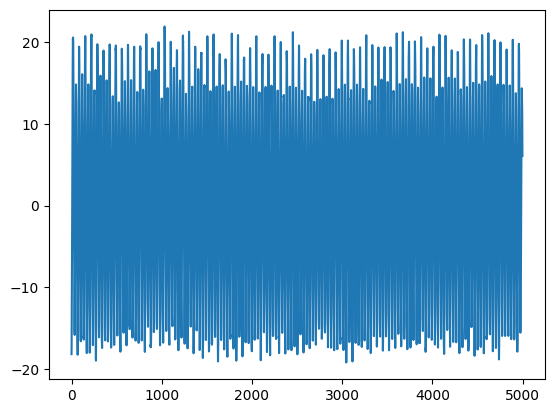

In [12]:
#raise NotImplementedError("Add your code here, and delete this.")
import matplotlib.pylab as plt

fig = plt.figure()
plt.plot(trace_array[0]-trace_array[1])

In [13]:
print(textin_array[0])
print(textin_array[1])

CWbytearray(b'36 8d f0 c0 aa 06 d1 ef 28 ab 54 71 23 e0 52 b2')
CWbytearray(b'13 dd 3e bf 5b 83 1c cc 6e a7 d6 f4 2c 04 3a 9b')


In [14]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

In [15]:
# ###################
# Add your code here
# ###################
# raise NotImplementedError("Add Your Code Here")
import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):
    
    one_list = []
    zero_list = []
    
    for trace_index in range(numtraces):
        
        #Get a hypothetical leakage list - use aes_internal(guess, input_byte)
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])
    
        #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
        if hypothetical_leakage & 0x01:        
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])
            
    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    mean_diffs[guess] = np.max(abs(one_avg - zero_avg))
    
    print("Guessing %02x: %f"%(guess, mean_diffs[guess]))

Guessing 00: 0.344424
Guessing 01: 0.707093
Guessing 02: 0.391871
Guessing 03: 0.302708
Guessing 04: 0.368603
Guessing 05: 0.272330
Guessing 06: 0.306592
Guessing 07: 0.339622
Guessing 08: 0.391402
Guessing 09: 0.333432
Guessing 0a: 0.536401
Guessing 0b: 0.385960
Guessing 0c: 0.345940
Guessing 0d: 0.340833
Guessing 0e: 0.331734
Guessing 0f: 0.377220
Guessing 10: 0.371576
Guessing 11: 0.383195
Guessing 12: 0.299104
Guessing 13: 0.258625
Guessing 14: 0.586525
Guessing 15: 0.549101
Guessing 16: 0.405098
Guessing 17: 0.352852
Guessing 18: 0.321221
Guessing 19: 0.560650
Guessing 1a: 0.317591
Guessing 1b: 0.393322
Guessing 1c: 0.460598
Guessing 1d: 0.254758
Guessing 1e: 0.299973
Guessing 1f: 0.271281
Guessing 20: 0.386763
Guessing 21: 0.449941
Guessing 22: 0.791791
Guessing 23: 0.418061
Guessing 24: 0.332429
Guessing 25: 0.314816
Guessing 26: 0.341193
Guessing 27: 0.288342
Guessing 28: 0.395881
Guessing 29: 0.449584
Guessing 2a: 0.358784
Guessing 2b: 1.746955
Guessing 2c: 0.290405
Guessing 2

In [16]:
def calculate_diffs(guess, byteindex=0, bitnum=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

In [17]:
from tqdm.notebook import trange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

for subkey in trange(0, 16, desc="Attacking Subkey"):
    max_diffs = [0]*256
    full_diffs = [0]*256
    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")

Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

Subkey  0 - most likely 2B (actual 2B)
 Top 5 guesses: 
   2B - Diff = 1.746955
   40 - Diff = 0.868272
   9C - Diff = 0.809321
   22 - Diff = 0.791791
   B9 - Diff = 0.737792


Subkey  1 - most likely 7E (actual 7E)
 Top 5 guesses: 
   7E - Diff = 1.661445
   92 - Diff = 0.886361
   8C - Diff = 0.773798
   77 - Diff = 0.762073
   AA - Diff = 0.742957


Subkey  2 - most likely 15 (actual 15)
 Top 5 guesses: 
   15 - Diff = 1.705569
   70 - Diff = 1.035228
   E0 - Diff = 0.726720
   87 - Diff = 0.718451
   61 - Diff = 0.714632


Subkey  3 - most likely 16 (actual 16)
 Top 5 guesses: 
   16 - Diff = 1.633536
   7D - Diff = 0.928433
   E4 - Diff = 0.851355
   8F - Diff = 0.811450
   AB - Diff = 0.783332


Subkey  4 - most likely 28 (actual 28)
 Top 5 guesses: 
   28 - Diff = 1.184143
   DD - Diff = 0.925595
   43 - Diff = 0.860505
   C4 - Diff = 0.835188
   62 - Diff = 0.693062


Subkey  5 - most likely AE (actual AE)
 Top 5 guesses: 
   AE - Diff = 0.949596
   A7 - Diff = 0.891691
   42 

End

In [18]:
from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

#Which bit to target
bitnum = 0

full_diffs_list = []

for subkey in tnrange(0, 1, desc="Attacking Subkey"):
    
    max_diffs = [0]*256
    full_diffs = [0]*256

    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
    
    #Make copy of the list
    full_diffs_list.append(full_diffs[:])
    
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")

C:\Users\admin\AppData\Local\Temp\ipykernel_4300\561709809.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 1, desc="Attacking Subkey"):


Attacking Subkey:   0%|          | 0/1 [00:00<?, ?it/s]

Subkey  0 - most likely 2B (actual 2B)
 Top 5 guesses: 
   2B - Diff = 1.746955
   40 - Diff = 0.868272
   9C - Diff = 0.809321
   22 - Diff = 0.791791
   B9 - Diff = 0.737792




In [19]:
from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

#Which bit to target
bitnum = 0

full_diffs_list = []

for subkey in tnrange(0, 16, desc="Attacking Subkey"):
    
    max_diffs = [0]*256
    full_diffs = [0]*256

    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
    
    #Make copy of the list
    full_diffs_list.append(full_diffs[:])
    
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, sorted_args[0], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")

C:\Users\admin\AppData\Local\Temp\ipykernel_4300\1406321624.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"):


Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

Subkey  0 - most likely 2B (actual 2B)
 Top 5 guesses: 
   2B - Diff = 1.746955
   40 - Diff = 0.868272
   9C - Diff = 0.809321
   22 - Diff = 0.791791
   B9 - Diff = 0.737792


Subkey  1 - most likely 7E (actual 7E)
 Top 5 guesses: 
   7E - Diff = 1.661445
   92 - Diff = 0.886361
   8C - Diff = 0.773798
   77 - Diff = 0.762073
   AA - Diff = 0.742957


Subkey  2 - most likely 15 (actual 15)
 Top 5 guesses: 
   15 - Diff = 1.705569
   70 - Diff = 1.035228
   E0 - Diff = 0.726720
   87 - Diff = 0.718451
   61 - Diff = 0.714632


Subkey  3 - most likely 16 (actual 16)
 Top 5 guesses: 
   16 - Diff = 1.633536
   7D - Diff = 0.928433
   E4 - Diff = 0.851355
   8F - Diff = 0.811450
   AB - Diff = 0.783332


Subkey  4 - most likely 28 (actual 28)
 Top 5 guesses: 
   28 - Diff = 1.184143
   DD - Diff = 0.925595
   43 - Diff = 0.860505
   C4 - Diff = 0.835188
   62 - Diff = 0.693062


Subkey  5 - most likely AE (actual AE)
 Top 5 guesses: 
   AE - Diff = 0.949596
   A7 - Diff = 0.891691
   42 

In [ ]:
cw.plot(full_diffs_list[5][0xC5]) * cw.plot(full_diffs_list[5][0xCB]) * cw.plot(full_diffs_list[5][0xAE])

In [ ]:
fig = cw.plot()
subkey = 12
for guess in range(0, 256):
    fig *= cw.plot(full_diffs_list[subkey][guess])
fig

In [20]:
fig = cw.plot()
for subkey in range(0, 16):
    fig *= cw.plot(full_diffs_list[subkey][known_key[subkey]])
fig

:Overlay
   .Curve.I    :Curve   [x]   (y)
   .Curve.II   :Curve   [x]   (y)
   .Curve.III  :Curve   [x]   (y)
   .Curve.IV   :Curve   [x]   (y)
   .Curve.V    :Curve   [x]   (y)
   .Curve.VI   :Curve   [x]   (y)
   .Curve.VII  :Curve   [x]   (y)
   .Curve.VIII :Curve   [x]   (y)
   .Curve.IX   :Curve   [x]   (y)
   .Curve.X    :Curve   [x]   (y)
   .Curve.XI   :Curve   [x]   (y)
   .Curve.XII  :Curve   [x]   (y)
   .Curve.XIII :Curve   [x]   (y)
   .Curve.XIV  :Curve   [x]   (y)
   .Curve.XV   :Curve   [x]   (y)
   .Curve.XVI  :Curve   [x]   (y)
   .Curve.XVII :Curve   [x]   (y)

In [ ]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add Your Code Here")
    
# ###################
# START SOLUTION
# ###################
from tqdm import tnrange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

#Which bit to target
bitnum = 0

full_diffs_list = []

for subkey in tnrange(0, 16, desc="Attacking Subkey"):
    
    max_diffs = [0]*256
    full_diffs = [0]*256

    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        full_diff_trace = full_diff_trace[(0 + subkey*0):]
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
    
    #Make copy of the list
    full_diffs_list.append(full_diffs[:])
    
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")
    
# ###################
# END SOLUTION
# ###################

C:\Users\admin\AppData\Local\Temp\ipykernel_4300\3133795240.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"):


Attacking Subkey:   0%|          | 0/16 [00:00<?, ?it/s]

Subkey  0 - most likely 2B (actual 2B)
 Top 5 guesses: 
   2B - Diff = 1.746955
   40 - Diff = 0.868272
   9C - Diff = 0.809321
   22 - Diff = 0.791791
   B9 - Diff = 0.737792


Subkey  1 - most likely 7E (actual 7E)
 Top 5 guesses: 
   7E - Diff = 1.661445
   92 - Diff = 0.886361
   8C - Diff = 0.773798
   77 - Diff = 0.762073
   AA - Diff = 0.742957


Subkey  2 - most likely 15 (actual 15)
 Top 5 guesses: 
   15 - Diff = 1.705569
   70 - Diff = 1.035228
   E0 - Diff = 0.726720
   87 - Diff = 0.718451
   61 - Diff = 0.714632


Subkey  3 - most likely 16 (actual 16)
 Top 5 guesses: 
   16 - Diff = 1.633536
   7D - Diff = 0.928433
   E4 - Diff = 0.851355
   8F - Diff = 0.811450
   AB - Diff = 0.783332


Subkey  4 - most likely 28 (actual 28)
 Top 5 guesses: 
   28 - Diff = 1.184143
   DD - Diff = 0.925595
   43 - Diff = 0.860505
   C4 - Diff = 0.835188
   62 - Diff = 0.693062


Subkey  5 - most likely AE (actual AE)
 Top 5 guesses: 
   AE - Diff = 0.949596
   A7 - Diff = 0.891691
   42 